<a href="https://colab.research.google.com/github/AnnaMakarova28/center-out/blob/main/all_dirs_Toroidal_topology_ECoG_data_center_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install cython

In [ ]:
pip install ripser

     |████████████████████████████████| 72 kB 543 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 47 kB 6.8 MB/s 
  Created wheel for ripser: filename=ripser-0.6.1-cp37-cp37m-linux_x86_64.whl size=455406 sha256=af6ca846d6d1a4ddbab85f81379276a36fa460dfdced8328af70f2117f18dba9
  Stored in directory: /root/.cache/pip/wheels/6b/e3/c8/209a9df47cc9af8c6d2dbee4db558dc129494d3f4fbd670285
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18120 sha256=96b5ea5b5520b7376f2029c8aa64a3be9799ae9e95662ae905ceb5395b0ba9a1
  Stored in directory: /root/.cache/pip/wheels/d2/9f/a8/67f1b86e47cd17338d3d07939f4660378e65b758c4594f96e3
Successfully built ripser hopcroftkarp


In [ ]:
pip install umap-learn

     |████████████████████████████████| 86 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 18.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=55bfb25f305141817f31d657280743f291d1ea1b88d7ed3125594b10665132bb
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=e79d6b52fa5cc1843bb567bd82b867cc786473ba43861cef2c637277da474f9b
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [ ]:
pip install mne

In [ ]:
import mne

In [ ]:
from ripser import ripser
from persim import plot_diagrams
import umap

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import scipy
import pywt


from sklearn.decomposition import PCA

In [ ]:
# Upload file from Google Drive (Center_out_project / Patient)
data_A = scipy.io.loadmat('/content/drive/MyDrive/Center_out_project/A/co_van_A_mov___ecog_trials_parsorted_valid.mat')

# Get an array of the data
# Result: data.shape = (1, 8) directions
data_A = data_A.get('co_van_A_mov___ecog_trials_parsorted_valid')

# Get data.shape = (8,) directions
data_A = np.squeeze(data_A)

# Reshape data => for each direction data (channels, trials, times)
for direction in range(data_A.size):
  data_A[direction] = data_A[direction].reshape(data_A[direction].shape[2], data_A[direction].shape[0], data_A[direction].shape[1])

In [ ]:
# Compute mean cwt (through trials) for each channel and direction
data_A_cwt = []
for direction in range(data_A.size):
  ch = []
  for channel in range(data_A[direction].shape[0]):
    cwt_mean = np.zeros((150,7168))
    for trial in range(data_A[direction].shape[1]):
      cwt, freqs = pywt.cwt(data_A[direction][channel][trial],np.arange(1,151),'morl')
      cwt_mean += cwt
    cwt_mean /= data_A[direction].shape[1]
    ch.append(cwt_mean)
  data_A_cwt.append(ch)

In [ ]:
# np.save('/content/drive/MyDrive/',data_A_cwt)

In [ ]:
data_A_cwt = np.array(data_A_cwt)
print(data_A_cwt.shape)

(8, 64, 150, 7168)


In [ ]:
# Same as previous but + notch filter 
'''
data_A_cwt = []
for direction in range(data_A.size):
  ch = []
  for channel in range(data_A[direction].shape[0]):
    cwt_mean = np.zeros((150,7168))
    for trial in range(data_A[direction].shape[1]):
      data_notch = mne.filter.notch_filter(data_A[direction][channel][trial], 2048, 50)
      cwt, freqs = pywt.cwt(data_notch, np.arange(1,151),'morl')
      cwt_mean += cwt
    cwt_mean /= data_A[direction].shape[1]
    ch.append(cwt_mean)
  data_A_cwt.append(ch)
data_A_cwt = np.array(data_A_cwt)
print(data_A_cwt.shape)
'''

In [ ]:
# Get matrix (ch, times) with max frequency in every time point
# data_A_cwt (8, 64, 150, 7168)
data_A_max_freq = []
for direction in range(data_A_cwt.shape[0]):
  max_freq = []
  for channel in range(data_A_cwt.shape[1]):
    max_freq.append(data_A_cwt[direction][channel].argmax(axis=0))
  data_A_max_freq.append(max_freq)

data_A_max_freq = np.array(data_A_max_freq)

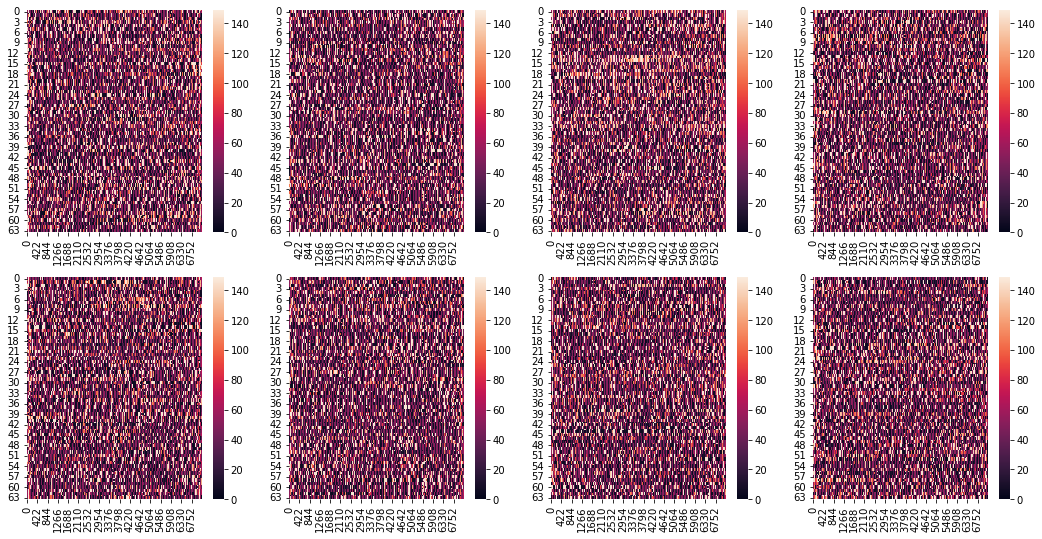

In [ ]:
plt.figure(figsize=(18,9))
for i in range(8):
  plt.subplot(2,4,i+1)
  sns.heatmap(data_A_max_freq[i])
  plt.title('direction %i' %(i+1))


In [ ]:
# z-score normalization and Gaussian smoothing
# data_A_max_freq (8, 64, 7168)
data_A_zscored = []
data_A_gaus = []
for direction in range(data_A_max_freq.shape[0]):
  # z-score normalization
  data_A_zscored.append(scipy.stats.zscore(data_A_max_freq[direction]))
  # Gaussian smoothing
  data_A_gaus.append(scipy.ndimage.gaussian_filter(data_A_zscored[direction], sigma=5))
data_A_gaus = np.array(data_A_gaus)

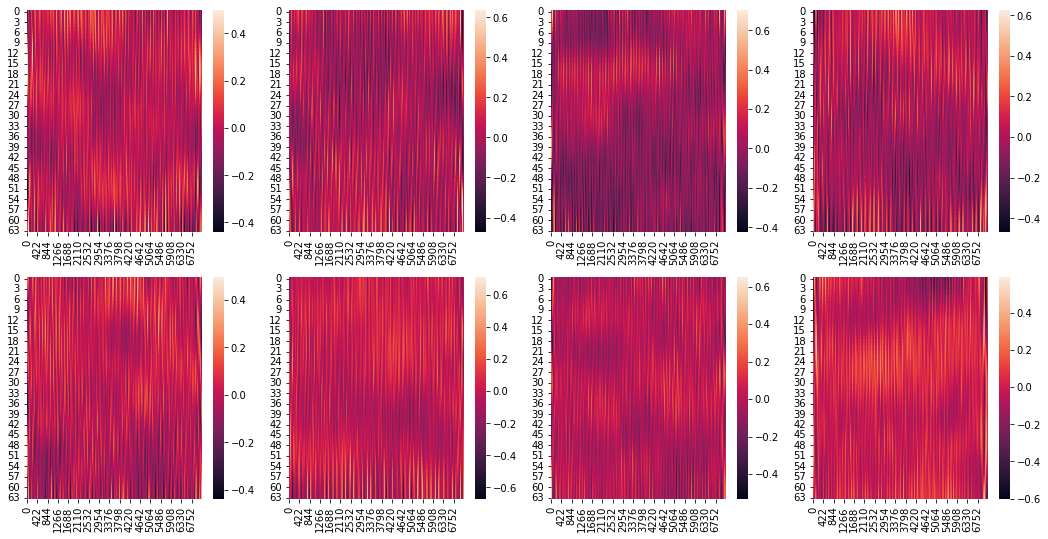

In [ ]:
plt.figure(figsize=(18,9))
for i in range(8):
  plt.subplot(2,4,i+1)
  sns.heatmap(data_A_gaus[i])
  plt.title('direction %i' %(i+1))


In [ ]:
# PCA
pca = PCA(n_components=5)

data_A_PCA = []

for direction in range(data_A_gaus.shape[0]):
  data_PCA = pca.fit(data_A_gaus[direction].T)
  data_A_PCA.append(data_PCA.transform(data_A_gaus[direction].T))

data_A_PCA = np.array(data_A_PCA)

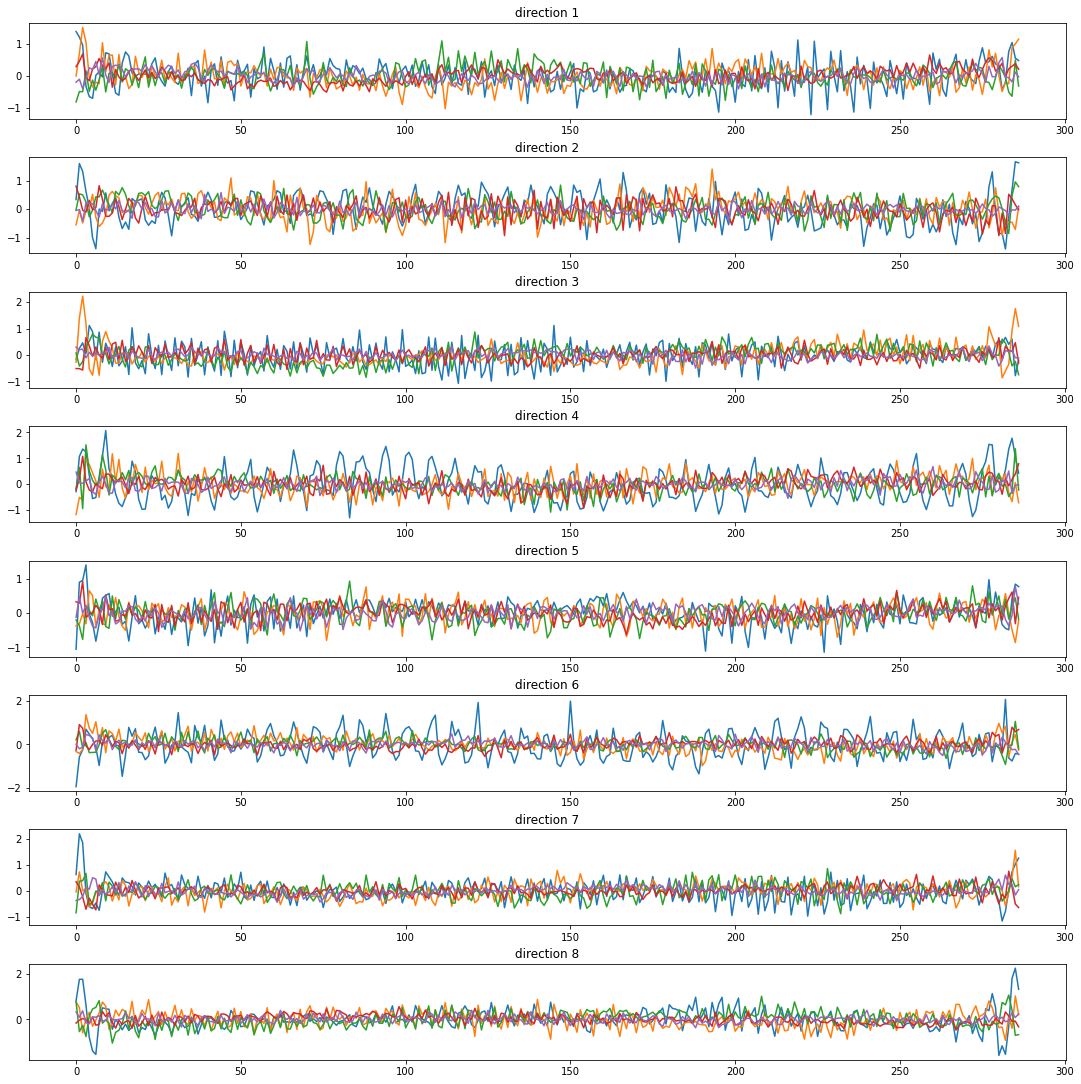

In [ ]:
plt.figure(figsize=(18,18))
for i in range(8):
  plt.subplot(8,1,i+1)
  plt.plot(data_A_PCA[i][0:7168:25])
  plt.title('direction %i' %(i+1))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

In [ ]:
# data_A_PCA_light => (directions, times/7, 5 PCs)
data_A_PCA_light = []
for direction in range(data_A_PCA.shape[0]):
  data_A_PCA_light.append(data_A_PCA[direction][0:7168:7])
data_A_PCA_light = np.array(data_A_PCA_light)

In [ ]:
embedding.shape

(8, 1024, 3)

In [ ]:
# Reduce dimentionality to 3D with UMAP => (times,3)
# embedding => (directions, times/7, 3)

embedding = []
for direction in range(data_A_PCA_light.shape[0]):
  reducer = umap.UMAP(n_components=3)
  embedding.append(reducer.fit_transform(data_A_PCA_light[direction]))
embedding = np.array(embedding)

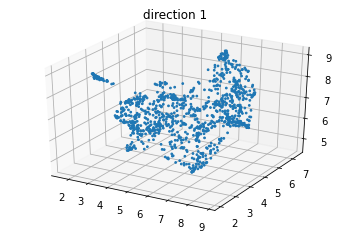

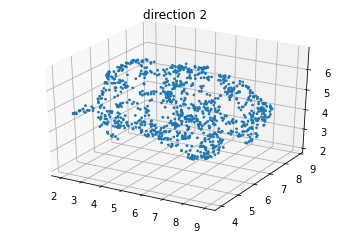

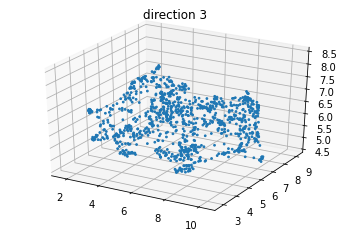

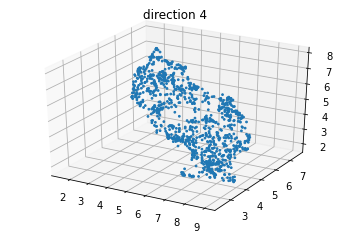

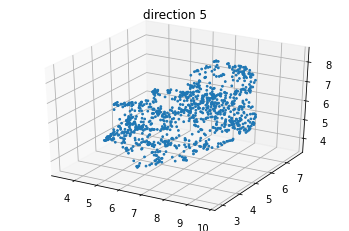

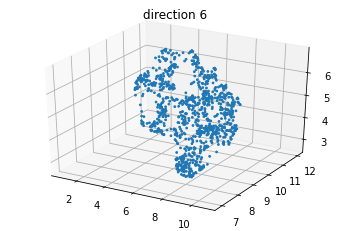

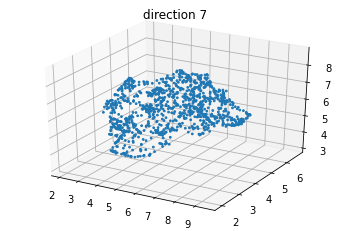

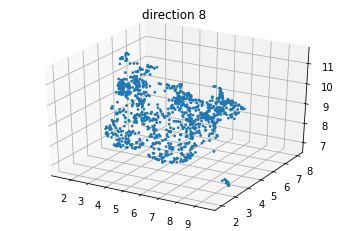

In [ ]:
for direction in range(embedding.shape[0]):
  plt.rcParams["figure.figsize"] = [6, 4]
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  x = embedding[direction].T[0]
  y = embedding[direction].T[1]
  z = embedding[direction].T[2]
  ax.scatter(x, y, z, alpha=1, s=3)
  plt.title('direction %i' %(direction+1))
  plt.show()

In [ ]:
diagrams = []
for direction in range(embedding.shape[0]):
  diagrams.append(ripser(embedding[direction])['dgms'])

In [ ]:
len(diagrams[0])

2

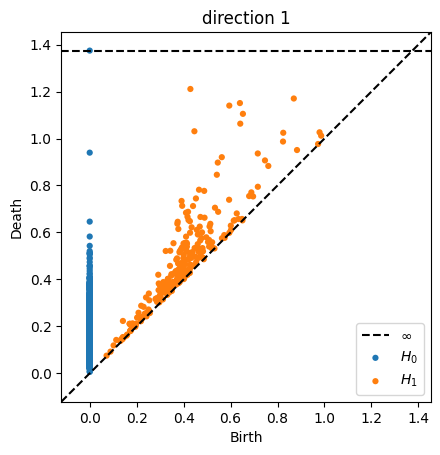

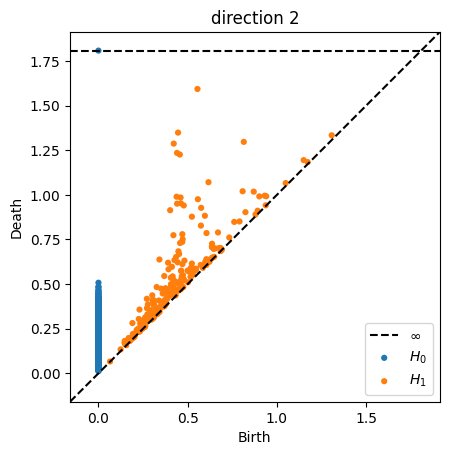

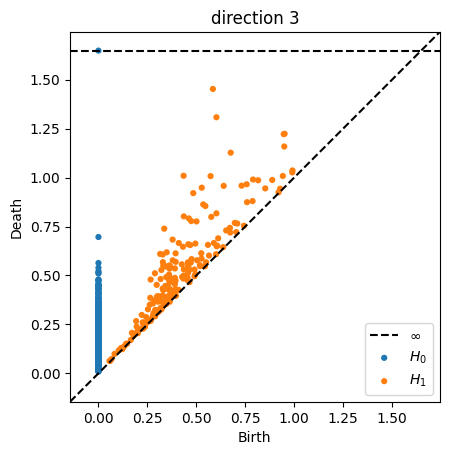

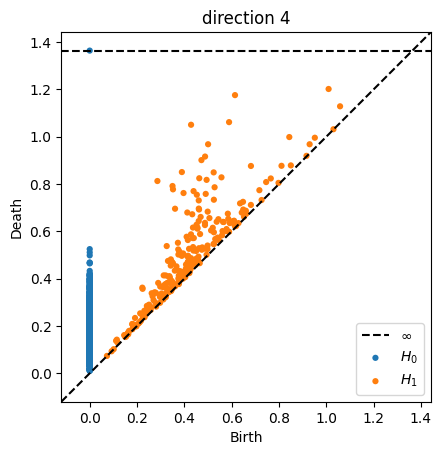

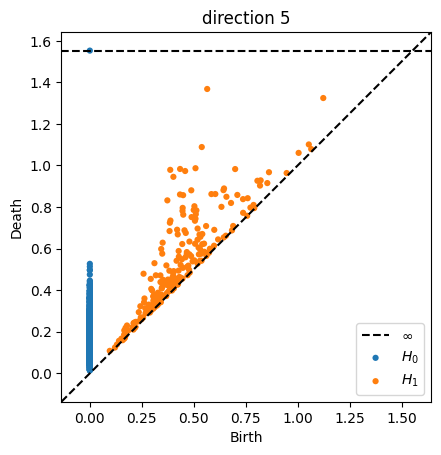

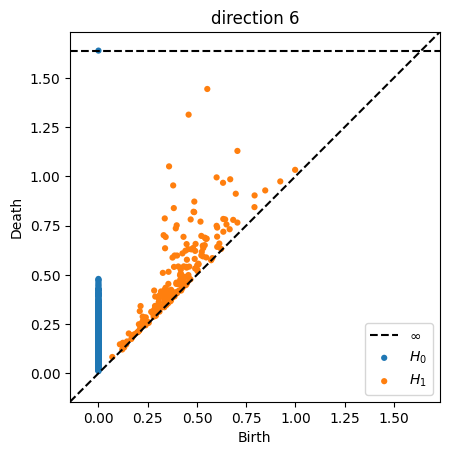

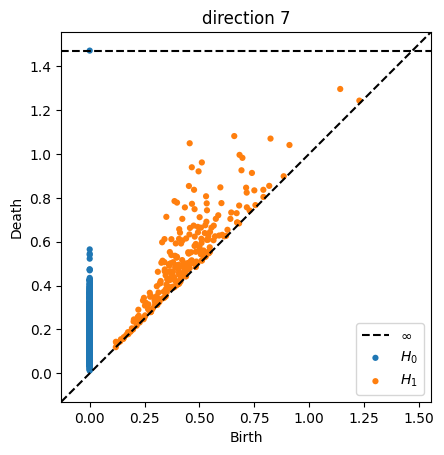

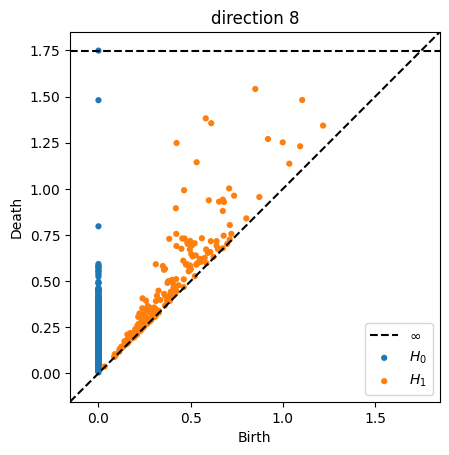

In [ ]:
for direction in range(len(diagrams)):
  # plt.figure(figsize=(4,4))
  plot_diagrams(diagrams[direction], show=True, title='direction %i' %(direction+1))
  # plt.title('direction %i' %(direction+1))
  plt.show()
